# Depresjon Classification


1. Import & Validate
2. Summary stats
3. Data Prep
   1. Feature Extraction
   2. Train-Test split
4. Modelling
   1. Selection
   2. Training
   3. Evaluation
   4. 

In [1]:
# libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Import 

### Functions list

1. **`exctract_csv`** Extract single csv file 
2. **`add_scores`** Add additional data, e.g. scores.csv to single df
3. **`extract_folder`** Extract all csvs
4. **`validate_missing`** Validate df for missing values

#### Extract single csv

In [31]:
# Extract single CSV file
def extract_csv(filepath, condition):
    """
    Extracts a single CSV file into a dataframe.

    Parameters:
    filepath (str): The path to the CSV file.
    condition (str): The condition associated with the data.

    Returns:
    pandas.DataFrame: The dataframe containing the CSV data with an additional 'condition' column.
    """
    try:
        df = pd.read_csv(filepath, on_bad_lines='error') 
        df['condition'] = condition
        return df
    except OSError:
        print(f"Error reading file: {filepath}")

##### Example single file extraction

In [32]:
# example condition_1.csv
fp1 = '../data/depresjon/condition/condition_1.csv'
condition = 1

file1 = extract_csv(fp1, condition)
print(file1.head())

             timestamp        date  activity  condition
0  2003-05-07 12:00:00  2003-05-07         0          1
1  2003-05-07 12:01:00  2003-05-07       143          1
2  2003-05-07 12:02:00  2003-05-07         0          1
3  2003-05-07 12:03:00  2003-05-07        20          1
4  2003-05-07 12:04:00  2003-05-07       166          1


#### Add scores file to df

In [33]:
# Add additional data to single df
def add_scores(df, subject, scores_file):
    """
    Adds data from scores.csv to a dataframe.
    
    Parameters:
    - df: pandas DataFrame to which the scores will be added.
    - subject: subject number for which the scores are being added.
    - scores_file: path to the scores.csv file.
    
    Returns:
    - df: pandas DataFrame with the scores added.
    """
    scores = pd.read_csv(scores_file)
    df['number'] = subject
    return df.merge(scores, left_on='number', right_on='number')

##### Example adding scores.csv to df

In [34]:
# example condition_1 df
scores_file = '../data/depresjon/scores.csv'
subject = 'condition_1'
fp1_with_scores = add_scores(file1, subject, scores_file)
print(fp1_with_scores.head())

             timestamp        date  activity  condition       number  days  \
0  2003-05-07 12:00:00  2003-05-07         0          1  condition_1    11   
1  2003-05-07 12:01:00  2003-05-07       143          1  condition_1    11   
2  2003-05-07 12:02:00  2003-05-07         0          1  condition_1    11   
3  2003-05-07 12:03:00  2003-05-07        20          1  condition_1    11   
4  2003-05-07 12:04:00  2003-05-07       166          1  condition_1    11   

   gender    age  afftype  melanch  inpatient   edu  marriage  work  madrs1  \
0       2  35-39      2.0      2.0        2.0  6-10       1.0   2.0    19.0   
1       2  35-39      2.0      2.0        2.0  6-10       1.0   2.0    19.0   
2       2  35-39      2.0      2.0        2.0  6-10       1.0   2.0    19.0   
3       2  35-39      2.0      2.0        2.0  6-10       1.0   2.0    19.0   
4       2  35-39      2.0      2.0        2.0  6-10       1.0   2.0    19.0   

   madrs2  
0    19.0  
1    19.0  
2    19.0  
3    19.

#### Extract all files in folder structure

In [35]:


def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """

    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # Concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # Final concat
    return df



##### Example extraction of all files in folder

In [57]:
# set folder path
folderpath = '../data/depresjon/'
# extract all files
all_files = extract_folder(folderpath)
# print rows 21-24
#print(all_files.iloc[21:25])
print(all_files.head(-5))


                  timestamp       date  activity           id  condition
0       2003-03-18 15:00:00 2003-03-18        60    control_1    control
1       2003-03-18 15:01:00 2003-03-18         0    control_1    control
2       2003-03-18 15:02:00 2003-03-18       264    control_1    control
3       2003-03-18 15:03:00 2003-03-18       662    control_1    control
4       2003-03-18 15:04:00 2003-03-18       293    control_1    control
...                     ...        ...       ...          ...        ...
1571696 2004-06-10 14:58:00 2004-06-10         0  condition_9  condition
1571697 2004-06-10 14:59:00 2004-06-10         0  condition_9  condition
1571698 2004-06-10 15:00:00 2004-06-10         0  condition_9  condition
1571699 2004-06-10 15:01:00 2004-06-10         5  condition_9  condition
1571700 2004-06-10 15:02:00 2004-06-10         0  condition_9  condition

[1571701 rows x 5 columns]


**Basic checks** on dataframe to validate function
* Looks as expected  &#128512;

In [58]:

# Check file

# check id column
print("There are", len(all_files['id'].unique()), "unique respondents.\n")

# print unique ids by condition
print(all_files.groupby('condition')['id'].nunique(), "\n")

#print(all_files['id'].unique())
# shape
print("There are", all_files.shape[0], "rows and", all_files.shape[1], "columns.\n")
#print(all_files.shape)
# print columns
print("The columns are:\n", all_files.columns, "\n")
#print(all_files.columns)

# print dtypes
print(all_files.dtypes, "\n")

# print unique conditions
#print(all_files['condition'].unique())

# print condition counts
print(all_files['condition'].value_counts(), "\n")

# print condition proportions
print(all_files['condition'].value_counts(normalize=True),"\n")



There are 55 unique respondents.

condition
condition    23
control      32
Name: id, dtype: int64 

There are 1571706 rows and 5 columns.

The columns are:
 Index(['timestamp', 'date', 'activity', 'id', 'condition'], dtype='object') 

timestamp    datetime64[ns]
date         datetime64[ns]
activity              int64
id                   object
condition            object
dtype: object 

control      1019990
condition     551716
Name: condition, dtype: int64 

control      0.64897
condition    0.35103
Name: condition, dtype: float64 



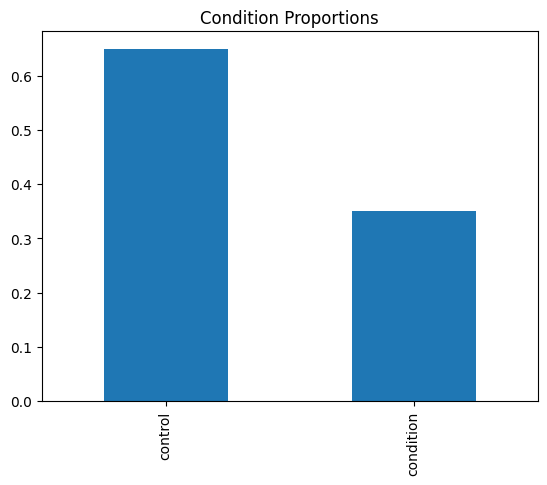

In [59]:
# Plot bar chart of condition proportions
all_files['condition'].value_counts(normalize=True).plot(kind='bar')
plt.title('Condition Proportions')
plt.show()


**Viewing** sample rows

In [65]:
# set seed
np.random.seed(1)
# print first 5 rows of all_files
print(all_files.head(), "\n\n")


# Get sample of 10 rows without replacement
sample = all_files.sample(n=10, replace=False) 

# print the sample
print(sample)

            timestamp       date  activity         id condition
0 2003-03-18 15:00:00 2003-03-18        60  control_1   control
1 2003-03-18 15:01:00 2003-03-18         0  control_1   control
2 2003-03-18 15:02:00 2003-03-18       264  control_1   control
3 2003-03-18 15:03:00 2003-03-18       662  control_1   control
4 2003-03-18 15:04:00 2003-03-18       293  control_1   control 


                  timestamp       date  activity            id  condition
1096536 2005-03-14 11:57:00 2005-03-14       212  condition_12  condition
547556  2006-01-24 18:02:00 2006-01-24       151    control_28    control
956768  2003-04-19 18:24:00 2003-04-19         0     control_7    control
1390019 2002-11-18 23:37:00 2002-11-18         0  condition_22  condition
593868  2002-11-09 02:45:00 2002-11-09         0     control_3    control
1441751 2003-06-01 02:27:00 2003-06-01       201   condition_3  condition
1412775 2002-06-20 18:16:00 2002-06-20       434  condition_23  condition
279147  2004-01-10 12

#### Validate for missing values

In [40]:

# Validate missing data
def validate_missing(df):
    missing = df.isna().sum()
    if missing.any():
        print(f'Missing values found in columns: {missing[missing > 0].index}')
    else:
        print('No missing values found.')
        
validate_missing(all_files)

No missing values found.


## Summary Statistics

In [41]:
# print summary statistics
print(all_files.describe())

           activity
count  1.571706e+06
mean   1.795652e+02
std    3.597233e+02
min    0.000000e+00
25%    0.000000e+00
50%    4.000000e+00
75%    2.020000e+02
max    8.000000e+03


In [66]:
# print categorical summary statistics
print(all_files.describe(include='object'), "\n")

# print info
print(all_files.info())

               id condition
count     1571706   1571706
unique         55         2
top     control_3   control
freq        65407   1019990 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571706 entries, 0 to 1571705
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1571706 non-null  datetime64[ns]
 1   date       1571706 non-null  datetime64[ns]
 2   activity   1571706 non-null  int64         
 3   id         1571706 non-null  object        
 4   condition  1571706 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 60.0+ MB
None


## Data Prep 

* There are a lot of rows - 1.5M for 55 respondents.
* One approach is to feature engineer the actigraphy data by `resampling`
* May be an opportunity to create a flexible function approach, with option to specify resample duration



### -> Feature Extraction


#### Simple resample function


In [46]:

def resample_data_v1(df, col, rule):
    """
    Resamples the given DataFrame by setting the index to the specified column and
    calculating the mean for each time interval based on the given rule.

    Args:
        df (pandas.DataFrame): The DataFrame to be resampled.
        col (str): The name of the column to be used as the new index.
        rule (str): The resampling rule, e.g., 'H' for hourly, 'D' for daily.

    Returns:
        pandas.DataFrame: The resampled DataFrame.
    """
    return df.set_index(col).resample(rule).mean()


##### Example resample (simple, test)

In [47]:
col = 'timestamp'
rule = '1H'

resampled = resample_data_v1(all_files, col, rule)
print(resampled.head(), "\n\n")
print(resampled.shape)

                       activity
timestamp                      
2002-05-24 11:00:00  145.300000
2002-05-24 12:00:00  128.633333
2002-05-24 13:00:00  135.400000
2002-05-24 14:00:00   72.016667
2002-05-24 15:00:00  249.700000 


(32691, 1)


C:\Users\zoona\AppData\Local\Temp\ipykernel_30892\600900001.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.set_index(col).resample(rule).mean()


#### Resampling function - reworked

* allows specifying frequency
* retains id, condition cols

In [79]:

def feature_engineering(df, resample_freq='1H'):
    """
    Perform feature engineering on time series data.

    Args:
      df (pd.DataFrame): Input DataFrame with timestamp, date, activity, id, and condition columns.
      resample_freq (str, optional): Resampling frequency, e.g., '1H' for hourly. Defaults to '1H'.

    Returns:
      pd.DataFrame: DataFrame with resampled features.
    """
    # copy of the DataFrame to avoid modifying the original data
    df_copy = df.copy()

    # convert timestamp and date columns to datetime, if not already
    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
    df_copy['date'] = pd.to_datetime(df_copy['date'])

    # timestamp as the index
    df_copy.set_index('timestamp', inplace=True)

    # create additional features from timestamp and date
    df_copy['hour'] = df_copy.index.hour
    df_copy['day_of_week'] = df_copy.index.dayofweek
    df_copy['day_of_month'] = df_copy.index.day
    df_copy['month'] = df_copy.index.month
    df_copy['year'] = df_copy.index.year

    # resample only numeric columns to the specified frequency and aggregate using mean
    numeric_columns = ['activity', 'hour', 'day_of_week', 'day_of_month', 'month', 'year']
    df_resampled = df_copy[numeric_columns].resample(resample_freq).mean()

    # retain 'id' and 'condition' columns, and use the first value in each group
    df_resampled[['id', 'condition']] = df_copy[['id', 'condition']].iloc[0]

    return df_resampled


##### Example use of function

In [77]:
# resample with functionm, 1H
resampled_df = feature_engineering(all_files, resample_freq='1H')


In [80]:
# print first 5 rows
print(resampled_df.head(), "\n\n")

# print shape
print(resampled_df.shape)

                       activity  hour  day_of_week  day_of_month  month  \
timestamp                                                                 
2002-05-24 11:00:00  145.300000  11.0          4.0          24.0    5.0   
2002-05-24 12:00:00  128.633333  12.0          4.0          24.0    5.0   
2002-05-24 13:00:00  135.400000  13.0          4.0          24.0    5.0   
2002-05-24 14:00:00   72.016667  14.0          4.0          24.0    5.0   
2002-05-24 15:00:00  249.700000  15.0          4.0          24.0    5.0   

                       year         id condition  
timestamp                                         
2002-05-24 11:00:00  2002.0  control_1   control  
2002-05-24 12:00:00  2002.0  control_1   control  
2002-05-24 13:00:00  2002.0  control_1   control  
2002-05-24 14:00:00  2002.0  control_1   control  
2002-05-24 15:00:00  2002.0  control_1   control   


(32691, 8)


### Train-Test split 



## Modelling

### Selection 

### Training

### Evaluaion



## to continue here



option LTSM - 3d shape needed (i.e. samples, time steps, features)

1. train-test split
2. model selection -> lstm
3. model training
4. model eval
5. what about imbalance?


3. next steps for classification model
4. vectorize operations like date filtering using pandas queries
5. convert to arays
6. preprocess by resampling to hourly (or create a function to specify resampling options??)
7. standard ml models -> logistic regression, svm, random forest
8. alternative approaches: 
   1. aggregate daily stats to use as features instead of sequence data
   2. complex engineered features like trend, autocorrelation
   3. sequence models like rnn instead of standard ml models

In [102]:
# 5. Preprocess - Resample and aggregate
def resample(df, rule):
    return df.set_index('timestamp').resample(rule).mean()


In [ ]:
# Resample to 1 hour
rule = '1H'
resampled = resample(all_files, rule)

In [ ]:

# 6. Feature engineering
def daily_features(df):
    return df.groupby('date').agg({'activity': ['mean', 'std', 'max']})